# CNN with a Trainable Embedding Layer

In [1]:
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

import numpy as np
import tensorflow as tf

## Build test and training sets & define preprocessing

In [22]:
NUM_WORDS = 50000
MAXLEN = 5000
NGRAM_RANGE = 1

In [23]:
train, test, preproc = text.texts_from_csv('../data/train.csv',
                                          'cleaned_contents',
                                          label_columns=['Discrimination_Label'],
                                          val_filepath='../data/test.csv',
                                          max_features=NUM_WORDS,
                                          maxlen=MAXLEN,
                                          ngram_range=NGRAM_RANGE)

detected encoding: utf-8 (if wrong, set manually)
language: en
Word Counts: 17751
Nrows: 647
647 train sequences
train sequence lengths:
	mean : 1526
	95percentile : 4005
	99percentile : 7619
x_train shape: (647,5000)
y_train shape: (647, 2)
Is Multi-Label? False
162 test sequences
test sequence lengths:
	mean : 1414
	95percentile : 3320
	99percentile : 7203
x_test shape: (162,5000)
y_test shape: (162, 2)


## Build the model

In [24]:
def _build_cnn(maxlen, max_features, embed_dim, filters, kernels,
               dropout=0.1,
               loss_func='categorical_crossentropy',
               activation = 'softmax', metrics=['accuracy'],
               verbose=1, optimizer='adam'):
    
    embedding_matrix = np.ones((max_features, 1))
    embedding_matrix[0] = 0

    # set up the model
    inp = tf.keras.layers.Input(shape=(maxlen,))
    x = tf.keras.layers.Embedding(max_features, embed_dim, input_length=maxlen, 
                                  trainable=True)(inp)
    x0 = tf.keras.layers.Conv1D(filters=filters,
                               kernel_size=kernels[0],
                               activation='relu')(x)
    x0 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[0] + 1)(x0)

    x1 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[1],
                                activation='relu')(x)
    x1 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[1] + 1)(x1)
    
    x2 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[2],
                                activation='relu')(x)
    x2 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[2] + 1)(x2)
    
    x3 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[3],
                                activation='relu')(x)
    x3 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[3] + 1)(x3)

    x4 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[4],
                                activation='relu')(x)
    x4 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[4] + 1)(x4)

    x = tf.keras.layers.concatenate([x0, x1, x2, x3, x4])

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(2, activation=activation)(x)
    model = tf.keras.Model(inputs=inp, outputs=outputs)
    model.compile(loss=loss_func,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [25]:
model = _build_cnn(5000, 50000, 100, filters=32, kernels=[2, 3, 4, 5, 6], dropout=0.4)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

In [26]:
learner.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 5000, 100)    5000000     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 4999, 32)     6432        embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 4998, 32)     9632        embedding_2[0][0]                
____________________________________________________________________________________________

## Define and train the model

In [27]:
learner.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 5000, 100)    5000000     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 4999, 32)     6432        embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 4998, 32)     9632        embedding_2[0][0]                
____________________________________________________________________________________________

### Find a good initial learning rate

This is a method that was developed at the Naval Research Laboratory.  It's been promoted by Jeremy Howard.

simulating training for different learning rates... this may take a few moments...
Train on 647 samples
Epoch 1/5
647/647 [==============================] - 6s 9ms/sample - loss: 0.6901 - accuracy: 0.5270
Epoch 2/5
647/647 [==============================] - 4s 7ms/sample - loss: 0.6947 - accuracy: 0.5085
Epoch 3/5
647/647 [==============================] - 4s 7ms/sample - loss: 0.6835 - accuracy: 0.5703
Epoch 4/5
647/647 [==============================] - 4s 7ms/sample - loss: 0.7629 - accuracy: 0.5889
Epoch 5/5
647/647 [==============================] - 4s 7ms/sample - loss: 0.7494 - accuracy: 0.5348


done.
Visually inspect loss plot and select learning rate associated with falling loss


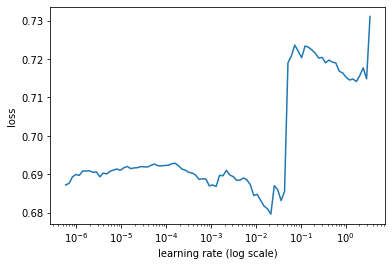

In [28]:
learner.lr_find(show_plot=True)

### Train

In [29]:
learner.autofit(0.01, early_stopping=5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 6s 9ms/sample - loss: 0.6897 - accuracy: 0.5657 - val_loss: 0.6106 - val_accuracy: 0.6605
Epoch 2/1024
647/647 [==============================] - 5s 7ms/sample - loss: 0.5779 - accuracy: 0.6924 - val_loss: 0.5137 - val_accuracy: 0.7222
Epoch 3/1024
647/647 [==============================] - 5s 7ms/sample - loss: 0.4745 - accuracy: 0.7743 - val_loss: 0.4984 - val_accuracy: 0.7593
Epoch 4/1024
647/647 [==============================] - 5s 7ms/sample - loss: 0.3180 - accuracy: 0.8779 - val_loss: 0.5656 - val_accuracy: 0.6667
Epoch 5/1024
640/647 [============================>.] - ETA: 0s - loss: 0.1623 - accuracy: 0.9484
Epoch 00005: Reducing Max LR on Plateau: new max lr will be 0.005 (if not early_stopping).
647/647 [==============================] - 5s 7ms

## Examine results

In [30]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

           0       0.66      0.82      0.73        65
           1       0.85      0.72      0.78        97

    accuracy                           0.76       162
   macro avg       0.76      0.77      0.76       162
weighted avg       0.78      0.76      0.76       162



array([[53, 12],
       [27, 70]])

## Explain a prediction

In [31]:
import pandas as pd
X_test = pd.read_csv('../data/test.csv')['cleaned_contents']

In [32]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [33]:
predictor.explain('As the perpetrator is the sole breadwinner for his family, I reduce his sentence by two years.')

In [34]:
learner.model.weights

[<tf.Variable 'embedding_2_1/embeddings:0' shape=(50000, 100) dtype=float32, numpy=
 array([[ 0.02031903,  0.04933965,  0.02865754, ..., -0.02265048,
          0.02572821, -0.00303656],
        [-0.04776132, -0.02554737, -0.05228696, ...,  0.03096877,
         -0.01573466,  0.03483898],
        [-0.00116059, -0.0070656 ,  0.0184384 , ...,  0.01672707,
          0.01151342, -0.00386575],
        ...,
        [-0.02912697, -0.04488286,  0.02484139, ..., -0.02298559,
          0.04920203,  0.0395076 ],
        [ 0.0131227 , -0.01408738, -0.03493637, ...,  0.03300157,
          0.00480126,  0.03733854],
        [ 0.00314789,  0.01440853, -0.0426978 , ...,  0.00273298,
          0.02354116, -0.02656016]], dtype=float32)>,
 <tf.Variable 'conv1d_10_1/kernel:0' shape=(2, 100, 32) dtype=float32, numpy=
 array([[[-0.1505433 , -0.00313068,  0.03599328, ...,  0.20086007,
           0.01085018, -0.05328671],
         [-0.11276166, -0.08721516, -0.03448695, ...,  0.11449168,
           0.10427706,  

In [35]:
learner.save_model('successful_cnn')

In [37]:
predictor.save('successful_cnn_predictor')

In [38]:
type(predictor.model)

tensorflow.python.keras.engine.training.Model

In [50]:
tf.keras.models.save_model(model, filepath='./cnn_model')

In [44]:
os.getcwd()

'/notebooks/w266/w266_project/CNNs'

In [47]:
os.path.exists('/notebooks/w266/w266_project/CNNs')

True

In [51]:
new_model = tf.keras.models.load_model('./cnn_model')

In [56]:
import pickle
with open('./cnn_predictor/tf_model.preproc', 'rb') as f: preproc = pickle.load(f)

In [58]:
new_predict = ktrain.get_predictor(new_model, preproc)

In [61]:
new_predict.explain('As the perpetrator is the sole breadwinner for his family, I reduce his sentence by two years.')

In [60]:
new_predict.model.load_weights('./cnn_predictor/tf_model.h5')